#### Sprawozdanie ponizej kodu

In [108]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
import matplotlib.collections as mcoll

In [2]:
class ShallowWaterEquationsIntegrator1D:
    def __init__(self, *, h_initial: np.ndarray, uh_initial: np.ndarray, bathymetry: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` and `uh`
        assuming constant inflow from right side """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        grid = h_initial.shape 
        stepper = Stepper(options=options, grid=grid)
        
        kwargs = {
            'boundary_conditions': [boundary_conditions.Extrapolated()] * len(grid),
            'halo': options.n_halo,
        }
        
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(uh_initial, **kwargs),
        }
        
        self.advector = VectorField((
                np.zeros(grid[0] + 1),
            ), **kwargs
        )
        
        self.bathymetry = bathymetry
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, g_times_dt_over_dx):
        """ applies half of the source term in the x direction """
        self[key][:] -= .5 * g_times_dt_over_dx * self['h'] * np.gradient(self['h'] - self.bathymetry, axis=0)

    def _update_courant_numbers(self, *, key, mask, dt_over_dx):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[all_but_last] + np.diff(velocity, axis=0) / 2 
        
        courant_number = self.advector.get_component(0)[all_but_first_and_last]
        
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dx
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dx: float, outfreq: int, eps: float=1e-7):
        output = {k: [] for k in self.solvers.keys()}
        
        # initial values fromm right side 
        # (constant inflow)
        inflow_h = self['h'][-1]
        inflow_uh = self['uh'][-1] 

        for it in range(nt + 1): 
            if it != 0:
                
                ### Boundries definitions ###

                # Left side - copying from [1]
                # Let water outflow
                self['h'][0] = self['h'][1]
                self['uh'][0] = self['uh'][1]

                # Right side - constant value
                # Inflow is not changing
                self['h'][-1] = inflow_h
                self['uh'][-1] = inflow_uh

                mask = self['h'] > eps
                
                self._update_courant_numbers(key="uh", mask=mask, dt_over_dx=dt_over_dx)
                self.solvers["h"].advance(n_steps=1)
                
                self['h'][0] = self['h'][1]
                self['h'][-1] = inflow_h

                self._apply_half_rhs(key="uh", g_times_dt_over_dx=g * dt_over_dx)
                self.solvers["uh"].advance(n_steps=1)
                self._apply_half_rhs(key="uh", g_times_dt_over_dx=g * dt_over_dx)

                self['uh'][0] = self['uh'][1]
                self['uh'][-1] = inflow_uh

            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
                    
        return output

In [ ]:
def generate_bathymetry(shape_type, grid_len, height, center, width):
    """
    1D bathymetry generator.
    shape_type: 'gaussian', 'flat'
    parameters: height, center, width
    """
    # base bathymetry
    b = np.zeros(grid_len) 
    
    x = np.arange(grid_len)
    
        
    if shape_type == 'gaussian':
        sigma = width / 2
        b -= height * np.exp(-((x - center)**2) / (2 * sigma**2))
        b += height
          
    return b

In [ ]:
t = 1000       #s
dt = 0.04  #s
dx = 0.5    #m

In [ ]:
def generate_output(obs_height, width, bathymetry='gaussian'):
    """
    Function that generate output using ShallowWaterEquationsIntegrator1D
    with given obs_height and width (type: 'gaussian')
    """
    grid_len = int(200 / dx)
    h_depth = 2.0   # m
    b = generate_bathymetry(
            shape_type=bathymetry, 
            grid_len=grid_len, 
            height=obs_height, 
            center=int(100 / dx), 
            width= int(width/dx)
        )   
    
    h_initial = b.copy() + h_depth - obs_height
    velocity = -1.  # m/s
    uh_initial = h_initial * velocity

    return (ShallowWaterEquationsIntegrator1D(
            h_initial=h_initial, 
            uh_initial=uh_initial,
            bathymetry=b
        )(
            nt=int(t/dt), 
            g=10, 
            dt_over_dx=dt/dx,
            outfreq=100
        )), b

In [ ]:
outputs = []
bathy = []
heights = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
width = 10 

for i in range(7):
    out, b = generate_output(heights[i], width)
    outputs.append(out)
    bathy.append(b)
    print(heights[i])

0.0
0.25
0.5
0.75
1.0
1.25
1.5


In [ ]:
# def plot(frame, *, zlim=(-0.1, 2.25)):
#     b = bathy[0]
#     psi = outputs[0]['h'][frame] - b + np.max(b)
    
#     x = np.arange(len(psi))
    
#     fig, ax = pyplot.subplots(figsize=(12, 6))
    
#     # bathymetry
#     ax.fill_between(x[:-5], zlim[0], np.max(b) - b[:-5], color='dimgray', alpha=0.5, label='Dno (b)')
#     ax.plot(x[:-5], np.max(b) - b[:-5], color='black', linewidth=1)

#     # Water
#     ax.fill_between(x[:-5], np.max(b) - b[:-5], psi[:-5], color='deepskyblue', alpha=0.3, label='Woda')
#     ax.plot(x[:-5], psi[:-5], color='blue', linewidth=1.5)

#     ax.set(
#         ylim=zlim, 
#         xlim=(0, len(psi[:-5])),
#         title=f"t / Δt = {frame}", 
#         # ylabel=r"Wysokość ($\zeta$)",
#         ylabel=r"Wysokość",
#         xlabel="x / Δx"
#     )
    
#     ax.grid(True, linestyle=':', alpha=0.6)
#     ax.legend(loc='upper right')

#     return fig

# show_anim(plot, range(len(outputs2[0]['h'])))

In [ ]:
def plot_colored_line(out, b, frame):
    """
    Function that plot 'u' as collor of line on 'h' plot
    """
    h = out['h'][frame]
    uh = out['uh'][frame]
    surface = h - b + np.max(b)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        u = np.where(h > 1e-4, uh / h, 0.0)
    
    x = np.linspace(0, 200-dx, len(h))
    
    fig, ax = pyplot.subplots(figsize=(10, 5))
    
    ax.fill_between(x, 0, np.max(b) - b, color='gray', alpha=0.5)
    ax.plot(x, np.max(b) - b, 'k', linewidth=1)
    
    ax.fill_between(x, np.max(b) - b, surface, color='lightblue', alpha=0.3)
    
    points = np.array([x, surface]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    

    lc = mcoll.LineCollection(segments, cmap='turbo', linewidth=2.5)
    lc.set_array(u)

    ax.add_collection(lc)
    
    
    cbar = pyplot.colorbar(lc, ax=ax)
    cbar.set_label('Prędkość u [m/s]')
    
    ax.set_ylim(0, np.max(b) + 2.0)
    ax.set_xlim(0, np.max(x))
    ax.set_title(f"Profil rzeki pokolorowany prędkością (t={frame})")


In [176]:
# plot_colored_line(outputs[0], bathy[0], -1)

In [ ]:
def plot_all_cases(outputs_list, bathymetries_list, frame):
    """
    Function that plot 'u' as collor of line on 'h' plot for all outputs
    """
    
    rows, cols = 3, 2
    fig, axes = pyplot.subplots(rows, cols, figsize=(18, 12), constrained_layout=True)
    
    
    axes_flat = axes.flatten()
    
    
    for i, ax in enumerate(axes_flat):
        
        if i >= len(outputs_list):
            ax.axis('off')
            continue
            
        
        out = outputs_list[i]
        b = bathymetries_list[i]
        
        h = out['h'][frame]
        uh = out['uh'][frame]

        surface = h - b + np.max(b)
        
        # Prędkość u = uh / h
        with np.errstate(divide='ignore', invalid='ignore'):
            u = np.where(h > 1e-4, uh / h, 0.0)
            
        x = np.linspace(0, len(h)*dx - dx, len(h))
        

        bed_profile = np.max(b) - b
        ax.fill_between(x, 0, bed_profile, color='gray', alpha=0.5)
        ax.plot(x, bed_profile, 'k', linewidth=1)
        
        ax.fill_between(x, bed_profile, surface, color='lightblue', alpha=0.3)
        
        points = np.array([x, surface]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        

        norm = pyplot.Normalize(vmin=-7.0, vmax=2.0) 
        
        lc = mcoll.LineCollection(segments, cmap='turbo', norm=norm, linewidth=2.5)
        lc.set_array(u)
        ax.add_collection(lc)
        

        ax.set_ylim(0, np.max(b) + 3.0) 
        ax.set_xlim(0, np.max(x))
        
        ax.set_title(f"\nWysokość progu: {heights[i]}", fontsize=12)
        ax.grid(True, linestyle=':', alpha=0.6)
        
        cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('u [m/s]', fontsize=8)

    fig.suptitle(f"Zestawienie wyników (t = {frame})", fontsize=16)
    show_plot("profil_u.pdf")

In [189]:
# plot_all_cases(outputs, bathy, -1)

In [164]:
def calc_h_ratio(out, b):
    h = out['h'][-1]
    uh = out['uh'][-1]
    surface = h - b + np.max(b)

    h_len = len(h)

    h_bef = h[int(3/4*h_len)]
    h_aft = h[int(1/4*h_len)]

    return (h_bef - h_aft)/h_bef

In [167]:
h_ratios = np.zeros(len(heights))
for i in range(len(heights)):
    h_ratios[i] = calc_h_ratio(outputs[i], bathy[i])

In [172]:
def plot_results():
    pyplot.plot(heights, h_ratios*100, 'o')
    pyplot.xlabel("Wysokość progu wodnego [m]")
    pyplot.title("Zalezność spadku głębokości wody od wysokości progu")
    pyplot.ylabel("Względny spadek głębokości [%]")
    # pyplot.yscale('log')
    pyplot.grid()
    show_plot('wyniki.pdf')

In [190]:
# plot_results()

In [ ]:
dt *= 2

out22t, b22t = generate_output(1.5, width)
dt /= 2

dx *= 2
out22x, b22x = generate_output(1.5, width)

dx /= 2

In [ ]:
def check_stability(out1, out2, out3, dx):
    vol = np.sum(out1['h'][-1]) * dx
    vol2 = np.sum(out2['h'][-1]) * dx*2
    vol3 = np.sum(out3['h'][-1]) * dx

    print(f"Objetosc dla dx:   {vol:.4f}")
    print(f"objetosc dla 2dx: {vol2:.4f}")
    print(f"objetosc dla 2dt: {vol3:.4f}")
    print(f"Różnica symulacji dx i 2dx: {abs(vol - vol2)/vol*100:.4f} %")
    print(f"Różnica symulacji dx i 2dt: {abs(vol - vol3)/vol*100:.4f} %")
    

# Sprawozdanie

##### Pytanie: Jak wysokość przeszkody na dnie rzeki wpływa na jej głębokość?

Celem projektu było przeprowadzenie symualcji przepływu rzeki z progiem wodnym. Rozwazany kształt progu to gaussian, z racji na brak nagłych skoków, a tym samym zniwelowania dodatkowych potencjalnych błędów numerycznych. 

Symulacja prowadzona była dla następujących parametrów:
- czas: $t = 500s$ natomiast $dt = 0.04s$ 
- długość rzeki: $x = 200m$ natomiast $dx = 0.5m$ 
- połozenie progu: $środek=100m$ natomiast $szerokość: 10m$ (szerokość to $\sigma$ dla gaussianu)
- badane wysokości progu: 0m (brak), 0.25m, 0.5m, 0.75m, 1m, 1.25m, 1.5m
- początkowa głębokość wody: 2m
- prędkość wodu: -1m/s (rzeka płynie w lewo)

Dla analizy wyników symulacji jedną istotną chwilą była ostatnia - początkowe załozenie tafli wody powoduje, ze glownym powodem dlugiego czasu symuaalcji jest potrzebny czas do ustalenia sie stabilnego stanu - stąd końcowe wyniki mają istotnie rózną głębokość niz początkowa.

Z tego powodu parametrem słuzącym do zbadania wpływu progu na rzekę, będzie procentowa zmiana głębokości w ustalonym miejscu za i przed progiem do głębokości przed progiem:

$$\Delta H_{\%} = \frac{ h_{przed} - h_{za}}{h_{przed}}$$

Zatem porównywane będą głębokości 50m przed i 50m za progiem.

Z powodu bardzo długiego czasu oczekiwania na ustalenie się powierzchni, symualcja była prowadzona dla przepływu jednowymiarowego (tylko 'uh'). 

Ponizsze wykresy przedstawiają poczatkowa wysokosc i predkosc dla poszczegolnych ukladow

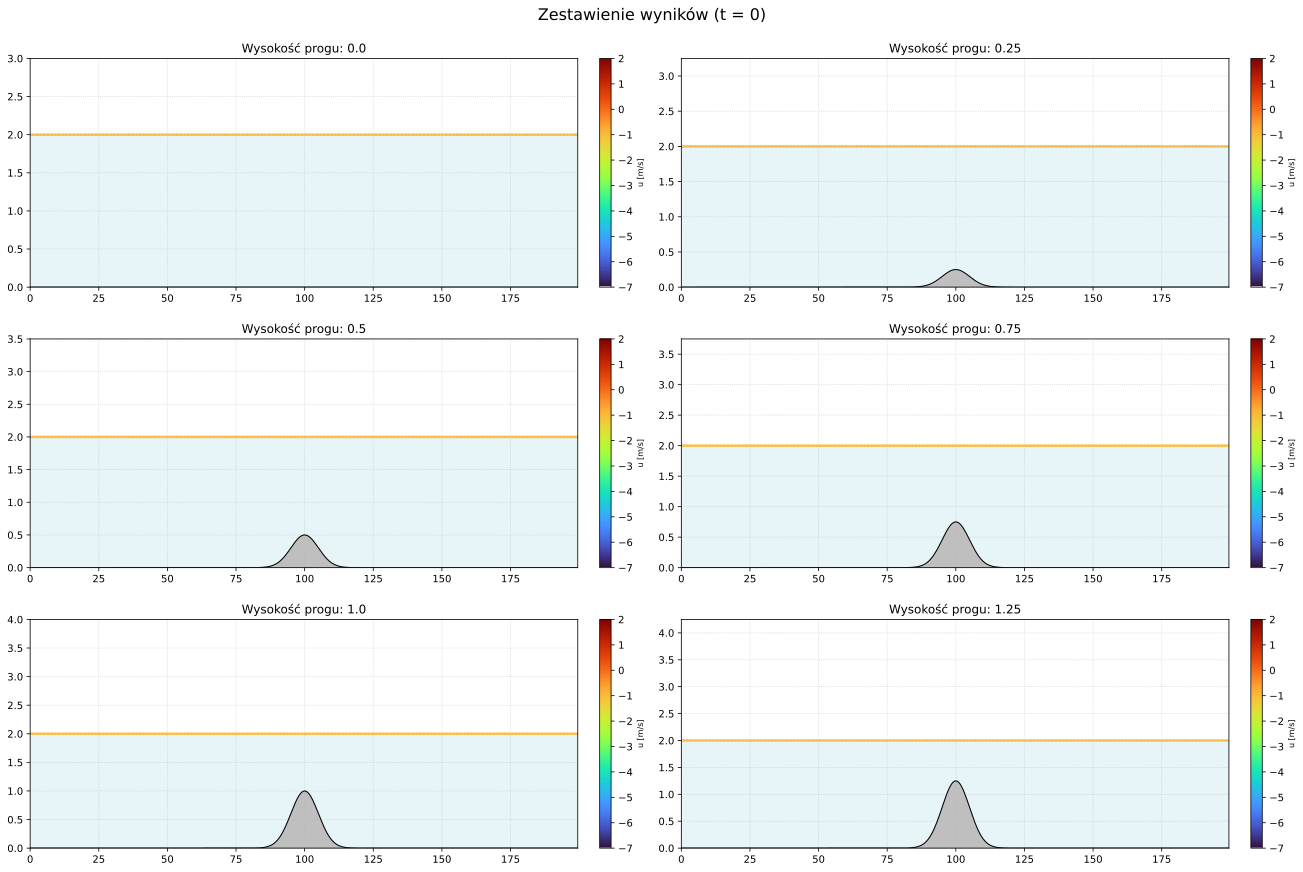

In [179]:
plot_all_cases(outputs, bathy, 0)

Po wykonanej symulacji wykresy przedstawiaja się nastepująco

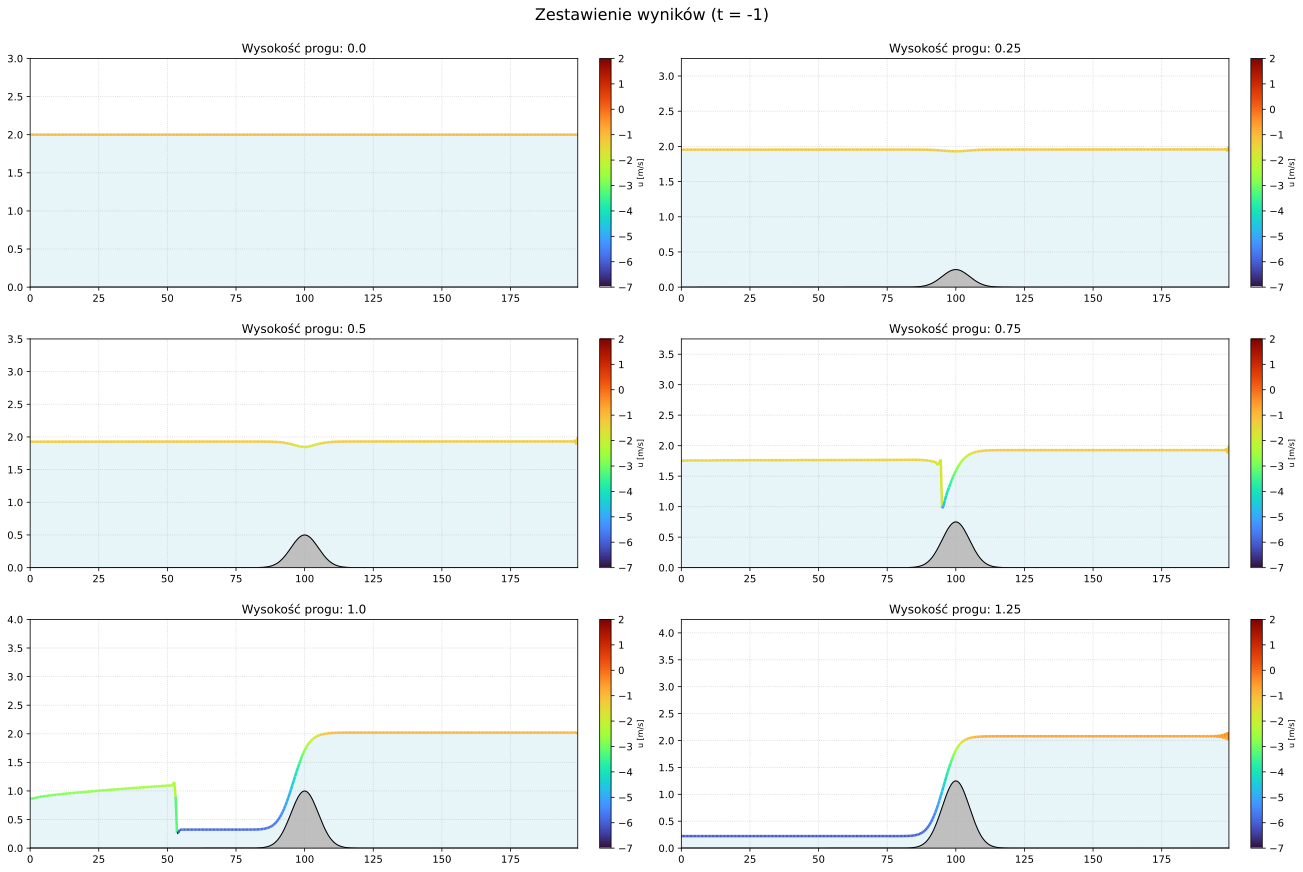

In [180]:
plot_all_cases(outputs, bathy, -1)

Widzimy, ze od wysokosci progu 0.75m głębokość rzeki zmienia się duzo bardziej. Dla mniejszych progów widzimy efekt wnęki - podnisienie się dna powoduje zmienijszonym miejscem dla wody, w zwiazku z tym woda przespiesza. Zatem z prawa Bernuliego ciśnienie spada co powoduje obnizenie poziomy rzeki. Dla większych wysokości progu woda ma za mało energi, zeby przepłynąc przez próg w związku z czym zaczyna się spiętrzać. Po drugiej stronie progu zgormadzona energia zamienia się w energię kinetyczną (predkość) co powoduje gwałtowne przyspieszenie i spływanie jak po tamie. 

Poniszy wykres przedstawia zaleznosc stosunku spadku wody od wysokosci progu. 

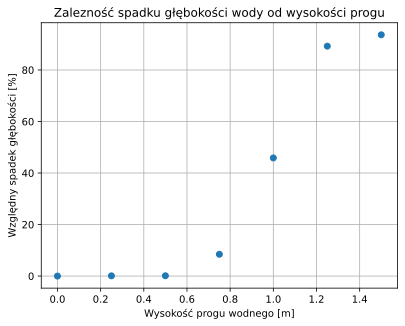

In [191]:
plot_results()

W celu sprawdzenia stabilność porównanie zostało pole pod wykresami w ostatnich chwili czasowej dla 2 razy wiekszego dt oraz dwa razy wiekszego dx, dla progu 1.5m

In [ ]:
check_stability(outputs[-1], out22x, out22t, dx)